In [1]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torchvision.transforms as T
import numpy as np
import matplotlib as plot
import os
import time

In [2]:
label_colors = []
for i in range(4):
    for j in range(4):
        for k in range(4):
            label_colors.append((i*64,j*64,k*64))
print(len(label_colors))

64


In [3]:
def encode_segmap(image, nc=64):
    #from (h,w,3) to (h,w)
    label = np.zeros((720,960))
    image = image // 64 * 64
    for i in range(720):
        for j in range(960):
            try:
                label[i,j] = label_colors.index(tuple(image[i,j,:]))
            except:
                label[i,j] = 0
    return label

def decode_segmap(image, nc=64):
    #from (h,w) to (h,w,3)
    rgb = np.zeros((720,960,3))
    for i in range(720):
        for j in range(960):
            rgb[i,j,:] = label_colors[int(image[i,j])]
    return rgb.astype(np.uint8)

## Use the encode_segmap function to encode the ground truth, because there are more than 21 classes in the Ground truth picture.

In [4]:
'''
target = 'SYNTHIA_RAND_CVPR16_extract-100-images/GT/'
label_dir = 'SYNTHIA_RAND_CVPR16_extract-100-images/label/'
for i,photo in enumerate(os.listdir(target)):
    path = target + photo
    label = np.array(Image.open(path).convert("RGB"))
    save_dir = label_dir + photo.split('.')[0] + '.npy'
    label = encode_segmap(label)
    np.save(save_dir,label)
    print('generating and saving label...[%d/%d]'%(i+1,len(os.listdir(target))),end='\r')
'''

'\ntarget = \'SYNTHIA_RAND_CVPR16_extract-100-images/GT/\'\nlabel_dir = \'SYNTHIA_RAND_CVPR16_extract-100-images/label/\'\nfor i,photo in enumerate(os.listdir(target)):\n    path = target + photo\n    label = np.array(Image.open(path).convert("RGB"))\n    save_dir = label_dir + photo.split(\'.\')[0] + \'.npy\'\n    label = encode_segmap(label)\n    np.save(save_dir,label)\n    print(\'generating and saving label...[%d/%d]\'%(i+1,len(os.listdir(target))),end=\'\r\')\n'

## Create the dataset for training

In [5]:
class DealDataset(torch.utils.data.Dataset):
    def __init__(self,images_path,labels_path,Transform = None,Transform_label = None):
        self.images_path_list = os.listdir(images_path)
        self.labels_path_list = [x.split('.')[0]+'.npy' for x in os.listdir(images_path)]
        self.transform = Transform
        self.transform_label = Transform_label
    def __getitem__(self,index):
        image_path = self.images_path_list[index]
        label_path = self.labels_path_list[index]
        
        image = Image.open(images_path + image_path).convert("RGB")
        label = np.load(labels_path + label_path)
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.transform_label is not None:
            label = self.transform_label(label)
        
        return image,label
        
    def __len__(self):
        return len(self.images_path_list)

images_path = 'SYNTHIA_RAND_CVPR16_extract-100-images/IMG/'
labels_path = 'SYNTHIA_RAND_CVPR16_extract-100-images/label/'
trf = T.Compose([T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
dataset = DealDataset(images_path,labels_path,Transform = T.Compose([T.ToTensor(),T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]),Transform_label = T.ToTensor())
print(dataset[0][0].shape,dataset[0][1].shape)

torch.Size([3, 720, 960]) torch.Size([1, 720, 960])


## Training part

In [6]:
model_64 = models.segmentation.fcn_resnet101(pretrained = False,num_classes=64)#64类模型
loss_fn  = torch.nn.CrossEntropyLoss()

use_cuda = True
if use_cuda:
    model_64.cuda()
    loss_fn.cuda()

save_list = []
for param_tensor in model_64.state_dict():
    if 'classifier' not in param_tensor and 'aux_classifier' not in param_tensor:
        save_list.append(param_tensor)#去掉不匹配的classifier和aux_classifier参数，保留共有的参数
model_21 = models.segmentation.fcn_resnet101(pretrained = True,num_classes=21)#载入21类模型

#把模型参数移植到64类之中

if use_cuda:
    load_state = {k: v.cuda() for k, v in model_21.state_dict().items() if k in save_list}
else:
    load_state = {k: v for k, v in model_21.state_dict().items() if k in save_list}

model_state = model_64.state_dict()
model_state.update(load_state)
model_64.load_state_dict(model_state)

#固定载入的参数
for name, value in model_64.named_parameters():
    if name in save_list:
        value.requires_grad = False

In [7]:
model_64.train()
optimizer = optim.Adam(model_64.parameters(), lr=0.001)
EPOCH = 10
loss_list = []
IOU_list = []
#训练没有固定的参数
start_time = time.time()
for epoch in range(EPOCH):
    print("======================EPOCH %d======================"%(epoch+1))
    loss_avg = 0
    for i in range(len(dataset)):
        if use_cuda:
            out = (model_64(dataset[i][0].cuda().unsqueeze(dim=0))['out'])
            target = dataset[i][1].cuda().long()
        else:
            out = (model_64(dataset[i][0].unsqueeze(dim=0))['out'])
            target = dataset[i][1].long()
        #print(out,target)
        loss = loss_fn(out,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_avg = loss_avg + loss.item()
        loss_avg = loss_avg/(i+1)
        secs = time.time()-start_time
        print('TIME[%02d:%02d:%02d] EPOCH[%d/%d] STEP[%d/%d] loss: %f'%(secs//3600, secs//60%60, secs%60, epoch+1, EPOCH, i+1, len(dataset), loss_avg))
    loss_list.append(loss_avg)

======================EPOCH 1======================
TIME[00:00:01] EPOCH[1/10] STEP[1/100] loss: 4.128603
TIME[00:00:02] EPOCH[1/10] STEP[2/100] loss: 3.553628
TIME[00:00:03] EPOCH[1/10] STEP[3/100] loss: 2.099168
TIME[00:00:04] EPOCH[1/10] STEP[4/100] loss: 1.103701
TIME[00:00:05] EPOCH[1/10] STEP[5/100] loss: 0.624476
TIME[00:00:06] EPOCH[1/10] STEP[6/100] loss: 0.421986
TIME[00:00:07] EPOCH[1/10] STEP[7/100] loss: 0.401924
TIME[00:00:08] EPOCH[1/10] STEP[8/100] loss: 0.266679
TIME[00:00:09] EPOCH[1/10] STEP[9/100] loss: 0.196343
TIME[00:00:10] EPOCH[1/10] STEP[10/100] loss: 0.147742
TIME[00:00:11] EPOCH[1/10] STEP[11/100] loss: 0.157637
TIME[00:00:12] EPOCH[1/10] STEP[12/100] loss: 0.195704
TIME[00:00:13] EPOCH[1/10] STEP[13/100] loss: 0.163191
TIME[00:00:14] EPOCH[1/10] STEP[14/100] loss: 0.102954
TIME[00:00:15] EPOCH[1/10] STEP[15/100] loss: 0.091248
TIME[00:00:16] EPOCH[1/10] STEP[16/100] loss: 0.090826
TIME[00:00:17] EPOCH[1/10] STEP[17/100] loss: 0.084591
TIME[00:00:18] EPOCH[1

## Save model

In [8]:
#保存模型
torch.save(model_64.state_dict(), 'ckpt.pth')

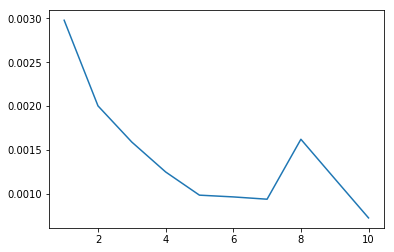

In [10]:
import matplotlib.pyplot as plt
x = range(1,11)
y = loss_list
plt.plot(x, y)
plt.show()

## Test the train file

In [12]:
#模型推理
checkpoint = torch.load('ckpt.pth')
model_64.load_state_dict(checkpoint)
model_64.eval()
out = (model_64(dataset[0][0].cuda().unsqueeze(dim=0))['out'])
out.shape

torch.Size([1, 64, 720, 960])

In [17]:
#展示函数
def display(x):
    if len(x.shape) == 4:
        x = torch.argmax(x,dim=1)
    if len(x.shape) == 3:
        img = decode_segmap(x.squeeze().cpu().numpy())
    else:
        img = decode_segmap(x.numpy())
    plt.imshow(img)
    plt.show()

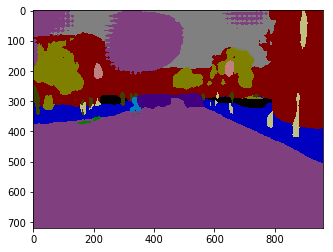

In [18]:
display(out)
#预测结果

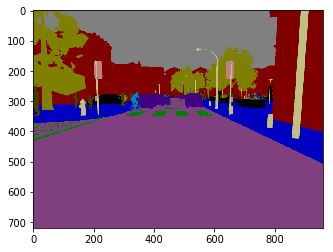

In [19]:
display(dataset[0][1])
#真实结果

In [21]:
#metric: confusion matrix and f1-score
nb_classes = 64
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i in range(len(dataset)):
        out = (model_64(dataset[i][0].cuda().unsqueeze(dim=0))['out'])
        pred = torch.argmax(out, 1)
        target = dataset[i][1]
        for t, p in zip(target.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
        print('processing NO.%d/%d...'%(i+1,len(dataset)),end='\r')
print('confusion_matrix:\n',confusion_matrix.numpy().astype(int))

confusion_matrix:/100...
 [[216177      0      0 ...      0   1280      0]
 [  3429      0      0 ...      0    107      0]
 [  5742      0      0 ...      0    194      0]
 ...
 [     0      0      0 ...      0      0      0]
 [  3596      0      0 ...      0 335742      0]
 [     0      0      0 ...      0      0      0]]


In [22]:
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print('precision:\n',(confusion_matrix.diag()/confusion_matrix.sum(1)).numpy())

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print('recall:\n',(confusion_matrix.diag()/confusion_matrix.sum(0)).numpy())

f1 = 2*precision*recall/(precision+recall)
print('f1-score:\n',f1.numpy())

precision:
 [6.84154212e-01 0.00000000e+00 0.00000000e+00 9.05966580e-01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.43414271e-02
 7.36162364e-01 0.00000000e+00 0.00000000e+00 7.31018186e-01
            nan            nan            nan            nan
 6.71727030e-05 0.00000000e+00 7.86336064e-01            nan
 4.02146637e-01 0.00000000e+00 2.61082983e-04            nan
 0.00000000e+00 0.00000000e+00 0.00000000e+00            nan
            nan            nan            nan            nan
 8.41535866e-01 0.00000000e+00            nan            nan
 1.78982136e-05 1.08498534e-04 9.79902387e-01            nan
 5.90409696e-01 9.42472555e-03 7.24071980e-01            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 6.74905956e-01            nan
            nan            nan 5.33453047e-01            nan]
recall:
 [0